In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from urllib.parse import unquote
from tqdm import tqdm 
import seaborn as sns
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot

dataFolder = '../Data/wikispeedia_paths-and-graph/'
articlesDf = pd.read_csv(dataFolder+ 'articles.tsv')
articlesDf = articlesDf.iloc[10:]
articlesSeries  = pd.Series(articlesDf.index.map(lambda x : x[0])).map(lambda y : unquote(y,'utf-8'))
#articlesSeries.head(10)

linksDf = pd.read_csv(dataFolder + 'links.tsv', header=11, sep = '\t')
linksDf.columns = ['Elements','links']
linksDf['Elements'] = linksDf['Elements'].map(lambda x : unquote(x, 'utf-8'))
linksDf['links'] = linksDf['links'].map(lambda x : unquote(x, 'utf-8'))
linksDf.reset_index()
print(linksDf.head(50))

categoriesDf = pd.read_csv(dataFolder + 'categories.tsv', header=11, sep= '\t')
categoriesDf.index = categoriesDf.index.map(lambda x : unquote(x,'utf-8'))
categoriesDf.columns = ['categories']
#categoriesDf

paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
#print(paths_finishedDf)

paths_unfinishedDf= pd.read_csv(dataFolder + 'paths_unfinished.tsv', header=16, sep= '\t')
paths_unfinishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'target', 'type']
#paths_unfinishedDf

             Elements                                      links
0   Áedán_mac_Gabráin                                    Columba
1   Áedán_mac_Gabráin                                  Dál_Riata
2   Áedán_mac_Gabráin                              Great_Britain
3   Áedán_mac_Gabráin                                    Ireland
4   Áedán_mac_Gabráin                                Isle_of_Man
5   Áedán_mac_Gabráin                                   Monarchy
6   Áedán_mac_Gabráin                                     Orkney
7   Áedán_mac_Gabráin                                      Picts
8   Áedán_mac_Gabráin                                   Scotland
9   Áedán_mac_Gabráin                                      Wales
10              Åland                               20th_century
11              Åland                                 Baltic_Sea
12              Åland                                Crimean_War
13              Åland                                   Currency
14              Åland    

On cherche à faire un lien entre nombre de liens par pages et nombres d'utilisations de cette même page. On commence par connaitre les pages contenant le plus de liens. 

In [79]:
links_per_page = linksDf.groupby('Elements',as_index=False).size()
links_per_page= links_per_page.rename(columns={'size': 'number_of_links'})
#print(links_per_page.head(20))
#print(len(links_per_page))

In [80]:
paths_finishedDf= pd.read_csv(dataFolder + 'paths_finished.tsv', header=15, sep= '\t')
paths_finishedDf.columns = ['hashedIpAddress',   'timestamp',   'durationInSec',  'path',  'rating']
paths = paths_finishedDf["path"].str.split(";", expand=True)

#Choisir un seuil adéquat !!!
seuil=1
hubs=pd.DataFrame(columns=['Elements', 'Occurrence'])
for i in range(0, paths.shape[1]):
    top_elements = paths.iloc[:, i].value_counts()
    elements_with_min_occurrences = top_elements[top_elements > seuil]
    
    # Créez un DataFrame temporaire pour les éléments et leurs occurrences
    temp_df = pd.DataFrame({'Elements': elements_with_min_occurrences.index, 'Occurrence': elements_with_min_occurrences.values})
    
    # Ajoutez le DataFrame temporaire à hubs
    hubs = pd.concat([hubs, temp_df], ignore_index=True)
hubs= hubs.groupby('Elements')['Occurrence'].sum().reset_index()

#Suppression '<' correspondant à des backclicks
valeur_a_supprimer = '<'
Hubs = hubs[hubs['Elements'] != valeur_a_supprimer]

# Réinitialisez l'indice si nécessaire
Hubs = Hubs.reset_index(drop=True)
#Hubs = Hubs.sort_values('Occurrence', ascending=False)


#print(Hubs.head(20))

                            Elements  number_of_links Occurrence
3567                   United_States              294       8875
1210                          Europe              159       4351
3563                  United_Kingdom              168       3894
1168                         England              172       3321
1082                           Earth              118       3215
109                           Africa              212       2778
3776                    World_War_II              119       2293
2495                   North_America               77       1871
1417                         Germany              169       1761
231                           Animal               29       1705
1679                           Human              137       1627
2166                          Mammal               42       1611
1317                          France               85       1604
859                         Computer               36       1542
3039                     

<Axes: xlabel='number_of_links', ylabel='Occurrence'>

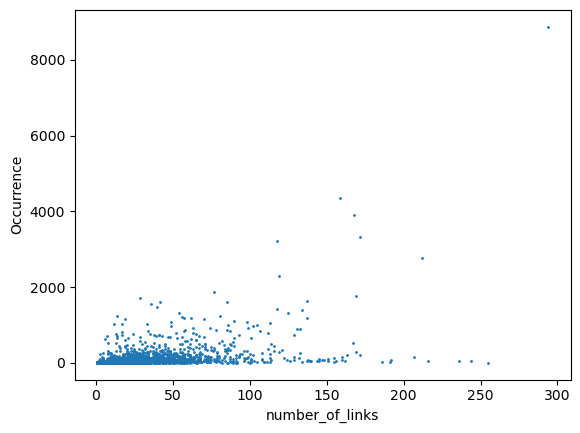

In [95]:
Hubs_and_links = links_per_page.merge(Hubs, on='Elements')
Hubs_and_links = Hubs_and_links.sort_values('Occurrence', ascending=False)
print(Hubs_and_links.head(50))
print(len(Hubs_and_links))

#Hubs_and_links.head(50).plot.bar(x="Elements", y="number_of_links")
Hubs_and_links.plot.scatter( x="number_of_links", y="Occurrence", s=1)
#Hubs_and_links.Occurrence.describe()

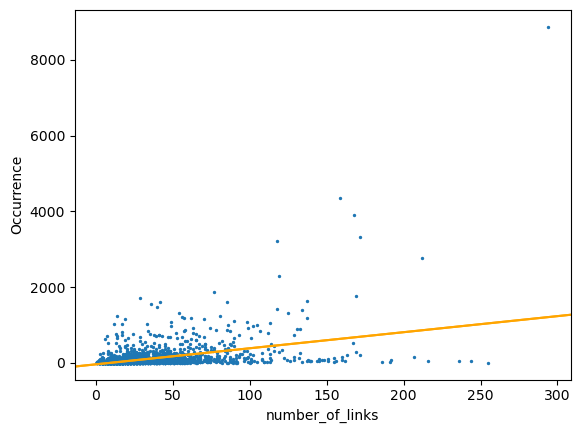

In [112]:
Hubs_and_links['Occurrence'] = pd.to_numeric(Hubs_and_links['Occurrence'])
mod = smf.ols(formula='Occurrence ~ number_of_links', data=Hubs_and_links)
ax = Hubs_and_links.plot(x='number_of_links', y='Occurrence', kind='scatter', s=2)

# plot regression line
abline_plot(model_results=mod.fit(), ax=ax, color='orange')